# ALL REGRESSIONS

In this version, all plotting will take place separately. We will save data to a csv and then plot from there. In doing so, we will be able save results.

Still need to implement the idea of train/test for linear regression: seeing how well our model works

In [9]:
Checker = Make_reg(n_samples=10, n_features=5)

In [15]:
Checker

(array([[-0.69325999, -0.57850812,  1.05883398, -1.96671766,  0.74450776],
        [ 0.66620342, -0.31744134,  0.28456364,  0.85099734,  0.1808318 ],
        [ 0.66369485, -0.31077032,  0.05207546,  0.66587232, -0.76439418],
        [ 0.22462066,  1.7296847 , -0.74572062, -1.2959899 , -0.26976383],
        [ 0.42225446,  0.57522894, -0.53372058, -0.9450512 ,  0.57463013],
        [ 1.00892554, -0.51319643,  1.29206199,  1.035759  , -0.1654116 ],
        [ 0.43862165, -0.44596295, -0.45442499, -0.86615865,  1.85496471],
        [-0.13801344, -1.03461046,  1.2002471 ,  0.21371354, -1.12226979],
        [ 0.44274389,  0.6892487 ,  2.14470037,  0.86979428, -1.9031582 ],
        [-1.54754235,  1.25879998, -0.37891756, -3.13108704, -1.47633346]]),
 array([  64.81490649,   76.04999013,  -11.49008353,  -45.76939564,
          33.90984356,  137.86796829,  125.77308318,  -22.0982314 ,
          41.07382355, -238.59149595]))

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from copy import deepcopy
from sklearn.datasets import make_regression as Make_reg # default is 100 samples, 100 features
from sklearn.datasets import make_classification as Make_class # default is 100 samples, 20 features, 2 classes
from sklearn.model_selection import train_test_split as split
def ren(x): return range(len(x))

class Regression:
    def __init__(self, error, time_limit):
        self.time_limit = time_limit
        self.error = error # epsilon/tolerence
            
    def makeLinearRegressionDataset(self): # make a dataset using sklearn's Make Regression
        dataset = Make_reg()
        self.a_copy = dataset[0]
        self.b_copy = dataset[1]
        self.x_copy = np.random.rand(len(self.a_copy[0]))
    
    def importLinearRegressionDataset(self, dataset): # import a regression dataset from sklearn
        dataset = dataset(return_X_y=True)
        self.a_copy = dataset[0]
        self.b_copy = dataset[1]
        self.x_copy = np.random.rand(len(self.a_copy[0]))
        
    def f_Lin(self, X): # linear Regression Function
        return 0.5 * np.linalg.norm(self.a @ X - self.b)**2
    def g_Lin(self, X): # linearRegressionFunctionGradient
        return self.a.T @ (self.a @ X - self.b)
    def GD_Lin(self): # Linear Regression gradient descent
        self.x = self.x - self.lam*self.grad
    
    def Vanilla_Linear_Reg(self, directory): # using a fixed step size of 1/L
        # set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.a = deepcopy(self.a_copy)
        self.b = deepcopy(self.b_copy)
        self.lam = 1/np.max( np.linalg.svd( self.a @ self.a.T ) [1] ) # find step size
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            self.GD_Lin()
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LinearVanDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearVanDF.to_csv(directory, index = False)
    
    def Adaptive_Linear_Reg(self, directory): # in which the step size adapts to local curvature
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.a = deepcopy(self.a_copy)
        self.b = deepcopy(self.b_copy)
        self.lam = random.random()+1e-12 # initialise step size > 0
        self.theta = np.inf # initialise theta = infty
        x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime] # to show time taken
        
        self.GD_Lin()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Lin(self.x)
        self.gradNorm = np.linalg.norm(self.grad)
        self.gradientValuesList.append(self.gradNorm)
        self.functionVals.append(self.f_Lin(self.x))
        self.timeList.append(time.time() - self.initialTime)
        # loop
        while self.gradNorm > self.error:
            lam0 = deepcopy(self.lam) # copy initial step size
            min1 = np.sqrt(1 + self.theta)*self.lam # 1st part of step size calc
            min2_nom = np.linalg.norm(self.x - x0) # 2nd part of step size calc
            min2_denom = 2*np.linalg.norm(self.grad - self.oldGrad) # as above
            self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
            x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
            self.GD_Lin() # steepest descent
            self.theta = self.lam / lam0 # calc theta
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LinearAdapDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearAdapDF.to_csv(directory, index = False)
    
    def Grad_LineSearch_Linear_Reg(self, directory): # using a line search
        def BackTrack():
            rho = random.random()
            lam = random.randrange(10)
            while 1 > ( self.gradNorm/np.linalg.norm(self.g_Lin(self.x - lam*self.grad) - self.grad) ):
                lam = rho * lam
                if self.time_limit > 0:
                    if (time.time() - self.initialTime) > self.time_limit:
                        return None
            self.lam = lam
            
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.a = deepcopy(self.a_copy)
        self.b = deepcopy(self.b_copy)
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            BackTrack()
            self.GD_Lin()
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LinearLineSearchDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearLineSearchDF.to_csv(directory, index = False)
            
    def Barzilai_Linear_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.a = deepcopy(self.a_copy)
        self.b = deepcopy(self.b_copy)
        self.lam = random.random()+1e-12 # initialise step size > 0
        x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime] # to show time taken
        self.GD_Lin()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList.append(self.gradNorm)
        self.functionVals.append(self.f_Lin(self.x))
        self.timeList.append(time.time() - self.initialTime)
        # loop
        while self.gradNorm > self.error:
            nom = np.dot(self.x - x0, self.grad - self.oldGrad )
            denom = np.linalg.norm(self.grad - self.oldGrad)**2
            self.lam = nom / denom            
            x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
            self.GD_Lin() # steepest descent
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LinearBarzDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearBarzDF.to_csv(directory, index = False)
        
    def Nesterov_Linear_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.a = deepcopy(self.a_copy)
        self.b = deepcopy(self.b_copy)
        L = np.max( np.linalg.svd( self.a @ self.a.T ) [1] )
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        lam1 = 1
        y0 = deepcopy(self.x)
        while self.gradNorm > self.error:
            self.lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
            self.gamma = (1 - lam1)/self.lam
            y1 = self.x - self.grad/L
            self.x = (1 - self.gamma)*y1 + self.gamma*y0
            lam1 = deepcopy(self.lam)
            y0 = deepcopy(y1)
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LinearNestDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearNestDF.to_csv(directory, index = False)
    
    #-------------------------------------------------------------------------------------------
    
    def makeLogisticRegressionDataset(self):
        sample_data = Make_class()
        ones = np.array([[1]*len(sample_data[0])])
        augmented_data = np.concatenate((ones.T, self.normalise(sample_data[0])), axis =1) # add a 1 to the start of each feature
        self.xTrain, self.xTest, self.yTrain, self.yTest = split( augmented_data, sample_data[1], \
                                                                 test_size = 0.1)
        self.weights_copy = np.random.rand( len(self.xTrain[0]) )
        
    def importLogisticRegressionDataset(self, dataset, multi = False):
        if multi == True:
            sample_data = dataset(return_X_y=True, n_class = 2)
        else:
            sample_data = dataset(return_X_y=True)
        ones = np.array([[1]*len(sample_data[0])])
        augmented_data = np.concatenate((ones.T, self.normalise(sample_data[0])), axis =1) # add a 1 to the start of each feature
        self.xTrain, self.xTest, self.yTrain, self.yTest = split( augmented_data, sample_data[1], \
                                                                 test_size = 0.1)
        self.weights_copy = np.random.rand( len(self.xTrain[0]) )
    
    def sigmoid(self, w, X): return 1.0/(1 + np.exp(-(X @ w))) # sigmoid function
    
    def normalise(self, X): # normalises the input data to values between 0 and 1
        mins = np.min(X, axis = 0) 
        maxs = np.max(X, axis = 0) 
        rng = maxs - mins 
        norm_X = 1 - ((maxs - X)/rng) 
        return norm_X
    
    def f_Log(self, W): # function f: the inverse of the log likelihood function, modelling the probability of the data xTrain and xTest
        sig = self.sigmoid(W, self.xTrain)
        step1 = self.yTrain * np.log(sig + 1e-300) # returns an array with log(sig) values where yTrain =1, else 0
        step2 = (1 - self.yTrain) * np.log(1 - sig + 1e-300 )
        final = -step1 - step2 
        return np.mean(final)
    
    def g_Log(self, W): # the gradient function of f, simply (h(w) - y) * x
        sig = self.sigmoid(W, self.xTrain)
        inner_expr = sig - self.yTrain
        return inner_expr.T @ self.xTrain
    
    def GD_Log(self): # Step size calculator - w_1 = w_0 - lam* gradient(w)
        self.weights = self.weights - self.lam * self.g_Log(self.weights)
        
    def classify(self):
        sig = self.sigmoid(self.weights, self.xTest)
        predict = np.squeeze( np.where( sig >= 0.5, 1, 0 ) )
        self.preds = sum( predict == self.yTest ) / len(self.xTest)
    
    def Vanilla_Logistic_Reg(self, directory):
        self.initialTime= time.time() # start the clock
        self.weights = deepcopy(self.weights_copy) # make a copy of the weights
        self.lam = 1/np.max(np.linalg.svd( self.xTrain @ self.xTrain.T )[1]) # find step size
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime]
        while self.gradNorm > self.error:
            self.GD_Log()
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LogisticVanDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals, 'Accuracy': self.predList})
        self.LogisticVanDF.to_csv(directory, index = False)
    
    def Adaptive_Logistic_Reg(self, directory):
        self.initialTime= time.time() # start the clock
        self.weights = deepcopy(self.weights_copy) # make a copy of the weights
        self.lam = random.random()+1e-12 # initialise step size > 0
        self.theta = np.inf # initialise theta = infty
        weights0 = deepcopy(self.weights) # make a coopy of weights to preserve previous weights
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime]
        
        self.GD_Log()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList.append(self.gradNorm)
        self.functionVals.append(self.f_Log(self.weights))
        self.classify()
        self.predList.append(self.preds)
        self.timeList.append(time.time() - self.initialTime)
        while self.gradNorm > self.error:
            lam0 = deepcopy(self.lam)
            min1 = np.sqrt(1 + self.theta)*self.lam # 1st part of step size calc
            min2_nom = np.linalg.norm(self.weights - weights0) # 2nd part of step size calc
            min2_denom = 2*np.linalg.norm(self.grad - self.oldGrad) # as above
            self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
            weights0 = deepcopy(self.weights) # make a coopy of x to preserve previous x
            self.GD_Log() # steepest descent
            self.theta = self.lam / lam0 # calc theta
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LogisticAdapDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals, 'Accuracy': self.predList})
        self.LogisticAdapDF.to_csv(directory, index = False)
        
    def Grad_LineSearch_Logistic_Reg(self, directory): # using a line search
        def BackTrack():
            rho = random.random()
            lam = random.randrange(10) # try using a less stupid number
            while 1>(self.gradNorm/np.linalg.norm(self.g_Log(self.weights - lam*self.grad) - self.grad)):
                lam = rho * lam
                if self.time_limit > 0:
                    if (time.time() - self.initialTime) > self.time_limit:
                        return None
            self.lam = lam
        #set up
        self.initialTime = time.time() # start the clock
        self.weights = deepcopy(self.weights_copy)
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            BackTrack()
            self.GD_Log()
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
#             k+=1
        self.LogisticLineDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals, 'Accuracy': self.predList})
        self.LogisticLineDF.to_csv(directory, index = False)
    
    def Barzilai_Logistic_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.weights = deepcopy(self.weights_copy) # make copies to use
        self.lam = random.random()+1e-12 # initialise step size > 0
        weights0 = deepcopy(self.weights) # make a copy of weughts to preserve previous weights
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime] # to show time taken
        
        self.GD_Log()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList.append(self.gradNorm)
        self.functionVals.append(self.f_Log(self.weights))
        self.classify()
        self.predList.append(self.preds)
        self.timeList.append(time.time() - self.initialTime)
        # loop
        k = 0
        while (self.gradNorm > self.error and k <10):
            nom = np.dot(self.weights - weights0, self.grad - self.oldGrad )
            denom = np.linalg.norm(self.grad - self.oldGrad)**2
            self.lam = nom / (denom +1e-300)           
            weight_backup = deepcopy(self.weights)
            self.GD_Log() # steepest descent
            # we don't update oldGrad in this loop
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
            k=k+1
        weights0 = weight_backup
        self.oldGrad = self.g_Log(weights0)
        while self.gradNorm > self.error:
            nom = np.dot(self.weights - weights0, self.grad - self.oldGrad )
            denom = np.linalg.norm(self.grad - self.oldGrad)**2
            self.lam = nom / (denom +1e-300)          
            weights0 = deepcopy(self.weights) # make a coopy of x to preserve previous x
            self.GD_Log() # steepest descent
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LogisticBarzDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals, 'Accuracy': self.predList})
        self.LogisticBarzDF.to_csv(directory, index = False)
        
    def Nesterov_Logistic_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        L = np.max(np.linalg.svd( self.xTrain @ self.xTrain.T )[1]) # find L
        self.weights = deepcopy(self.weights_copy) # make copies to use
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        lam1 = 1
        y0 = deepcopy(self.weights)
        self.timeList = [time.time() - self.initialTime]
        while self.gradNorm > self.error:
            self.lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
            self.gamma = (1 - lam1)/self.lam 
            y1 = self.weights - self.grad/L
            self.weights = (1 - self.gamma)*y1 + self.gamma*y0
            lam1 = deepcopy(self.lam)
            y0 = deepcopy(y1)
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LogisticNestDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals, 'Accuracy': self.predList})
        self.LogisticNestDF.to_csv(directory, index = False)

def RunAll(error, runtime, date_time):
    global H
    H = Regression(error, runtime)
    run_lin(date_time)
    print('Linear Regression complete')
    run_log(date_time)
    print('Logistic Regression complete')
    read_lin(date_time)
    read_log(date_time)

def run_lin(date_time):
    H.makeLinearRegressionDataset()
    H.Adaptive_Linear_Reg("output/Lin_Test_Adap_{}.csv".format(date_time))
    H.Grad_LineSearch_Linear_Reg("output/Lin_Test_LS_{}.csv".format(date_time))
    H.Vanilla_Linear_Reg("output/Lin_Test_Van_{}.csv".format(date_time))
    H.Barzilai_Linear_Reg("output/Lin_Test_Baz_{}.csv".format(date_time))
    H.Nesterov_Linear_Reg("output/Lin_Test_Nest_{}.csv".format(date_time))
def read_lin(date_time):
    global Lin_vanilla_out
    Lin_vanilla_out = pd.read_csv("output/Lin_Test_Van_{}.csv".format(date_time))
    global Lin_adap_out
    Lin_adap_out = pd.read_csv("output/Lin_Test_Adap_{}.csv".format(date_time))
    global Lin_line_out
    Lin_line_out = pd.read_csv("output/Lin_Test_LS_{}.csv".format(date_time))
    global Lin_baz_out
    Lin_baz_out = pd.read_csv("output/Lin_Test_Baz_{}.csv".format(date_time))
    global Lin_nest_out
    Lin_nest_out = pd.read_csv("output/Lin_Test_Nest_{}.csv".format(date_time))

def run_log(date_time):
    H.makeLogisticRegressionDataset()
    H.Adaptive_Logistic_Reg("output/Log_Test_Adap_{}.csv".format(date_time))
    H.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_{}.csv".format(date_time))
    H.Vanilla_Logistic_Reg("output/Log_Test_Van_{}.csv".format(date_time))
    H.Barzilai_Logistic_Reg("output/Log_Test_Baz_{}.csv".format(date_time))
    H.Nesterov_Logistic_Reg("output/Log_Test_Nest_{}.csv".format(date_time))
def read_log(date_time):
    global Log_vanilla_out
    Log_vanilla_out = pd.read_csv("output/Log_Test_Van_{}.csv".format(date_time))
    global Log_adap_out
    Log_adap_out = pd.read_csv("output/Log_Test_Adap_{}.csv".format(date_time))
    global Log_line_out
    Log_line_out = pd.read_csv("output/Log_Test_LS_{}.csv".format(date_time))
    global Log_baz_out
    Log_baz_out = pd.read_csv("output/Log_Test_Baz_{}.csv".format(date_time))
    global Log_nest_out
    Log_nest_out = pd.read_csv("output/Log_Test_Nest_{}.csv".format(date_time))

In [12]:
def endpoint(source, target):
    return np.argmax(np.where(target.TimeTaken > source.TimeTaken.iloc[-1],1,0))

In [2]:
RunAll(1e-6,60,"16.08.21_12.14")

<ipython-input-1-cf99a8526701>:114: RuntimeWarning: divide by zero encountered in double_scalars
  while 1 > ( self.gradNorm/np.linalg.norm(self.g_Lin(self.x - lam*self.grad) - self.grad) ):


Linear Regression complete


<ipython-input-1-cf99a8526701>:244: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, w, X): return 1.0/(1 + np.exp(-(X @ w))) # sigmoid function
<ipython-input-1-cf99a8526701>:353: RuntimeWarning: divide by zero encountered in double_scalars
  while 1>(self.gradNorm/np.linalg.norm(self.g_Log(self.weights - lam*self.grad) - self.grad)):


Logistic Regression complete


# Linear Regression Output

Full plot

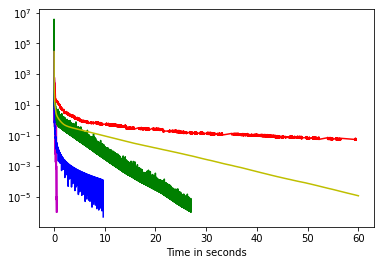

In [10]:
plt.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'm')
plt.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'g')
plt.plot(Lin_line_out.TimeTaken.iloc[:-1], Lin_line_out.GradientNorms.iloc[:-1], c = 'r')
plt.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'b')
plt.plot(Lin_vanilla_out.TimeTaken, Lin_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

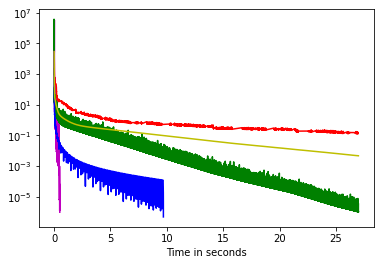

In [13]:
plt.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'm')
plt.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'g')
plt.plot(Lin_line_out.TimeTaken.iloc[:endpoint(Lin_adap_out, Lin_line_out)], Lin_line_out.GradientNorms.iloc[:endpoint(Lin_adap_out, Lin_line_out)], c = 'r')
plt.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'b')
plt.plot(Lin_vanilla_out.TimeTaken.iloc[:endpoint(Lin_adap_out, Lin_vanilla_out)], Lin_vanilla_out.GradientNorms.iloc[:endpoint(Lin_adap_out, Lin_vanilla_out)], c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

In [6]:
Lin_adap_out.TimeTaken.iloc[-1]

26.989213705062863

In [4]:
print("Van final", Lin_vanilla_out.tail())
print("Adap final", Lin_adap_out.tail())
print("LS final", Lin_line_out.tail())
print("Baz final", Lin_baz_out.tail())
print("Nest final", Lin_nest_out.tail())

Van final         GradientNorms  TimeTaken  FunctionValues
214744       0.000011  59.998933    3.316261e-09
214745       0.000011  59.999428    3.315925e-09
214746       0.000011  59.999428    3.315589e-09
214747       0.000011  59.999926    3.315254e-09
214748       0.000011  60.000422    3.314918e-09
Adap final        GradientNorms  TimeTaken  FunctionValues
76864   2.869535e-06  26.987726    2.658376e-11
76865   1.447956e-06  26.988222    2.657386e-11
76866   1.112890e-06  26.988719    2.657127e-11
76867   1.011171e-06  26.989214    2.656911e-11
76868   9.998316e-07  26.989214    2.656627e-11
LS final       GradientNorms  TimeTaken  FunctionValues
8105       0.049054  59.497582        0.059966
8106       0.059569  59.512958        0.059943
8107       0.052579  59.571981        0.059933
8108       0.049808  59.572973        0.059922
8109       0.048525  60.000028        0.059912
Baz final       GradientNorms  TimeTaken  FunctionValues
1514   6.289344e-05   0.508399    2.334474e-11
15

# Logistic Regression output

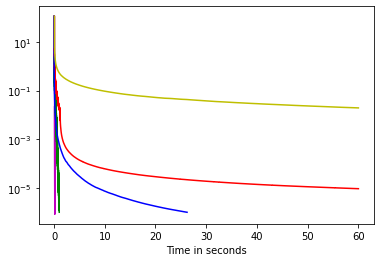

In [5]:
plt.plot(Log_baz_out.TimeTaken, Log_baz_out.GradientNorms, c = 'm')
plt.plot(Log_adap_out.TimeTaken, Log_adap_out.GradientNorms, c = 'g')
plt.plot(Log_line_out.TimeTaken, Log_line_out.GradientNorms, c = 'r')
plt.plot(Log_nest_out.TimeTaken, Log_nest_out.GradientNorms, c = 'b')
plt.plot(Log_vanilla_out.TimeTaken, Log_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

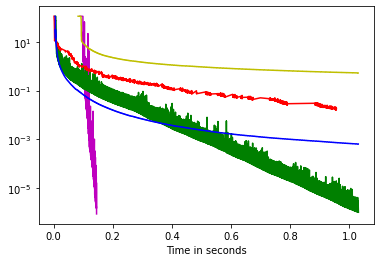

In [16]:
plt.plot(Log_baz_out.TimeTaken, Log_baz_out.GradientNorms, c = 'm')
plt.plot(Log_adap_out.TimeTaken, Log_adap_out.GradientNorms, c = 'g')
plt.plot(Log_line_out.TimeTaken.iloc[:endpoint(Log_adap_out,Log_line_out)], Log_line_out.GradientNorms.iloc[:endpoint(Log_adap_out,Log_line_out)], c = 'r')
plt.plot(Log_nest_out.TimeTaken.iloc[:endpoint(Log_adap_out,Log_nest_out)], Log_nest_out.GradientNorms.iloc[:endpoint(Log_adap_out,Log_nest_out)], c = 'b')
plt.plot(Log_vanilla_out.TimeTaken.iloc[:endpoint(Log_adap_out,Log_vanilla_out)], Log_vanilla_out.GradientNorms.iloc[:endpoint(Log_adap_out,Log_vanilla_out)], c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

In [17]:
print("Van final", Log_vanilla_out.tail())
print("Adap final", Log_adap_out.tail())
print("LS final", Log_line_out.tail())
print("Baz final", Log_baz_out.tail())
print("Nest final", Log_nest_out.tail())

Van final         GradientNorms  TimeTaken  FunctionValues  Accuracy
447218       0.019449  59.999996        0.003451       0.9
447219       0.019449  59.999996        0.003451       0.9
447220       0.019449  59.999996        0.003451       0.9
447221       0.019449  59.999996        0.003451       0.9
447222       0.019449  60.000492        0.003451       0.9
Adap final       GradientNorms  TimeTaken  FunctionValues  Accuracy
5727   1.018332e-06   1.030190    1.816979e-07       0.9
5728   1.003778e-06   1.030190    1.815790e-07       0.9
5729   1.002748e-06   1.030685    1.813936e-07       0.9
5730   1.001106e-06   1.030685    1.810962e-07       0.9
5731   9.985088e-07   1.030685    1.806178e-07       0.9
LS final         GradientNorms  TimeTaken  FunctionValues  Accuracy
388273       0.000009  59.999501        0.000002       0.9
388274       0.000009  59.999996        0.000002       0.9
388275       0.000009  59.999996        0.000002       0.9
388276       0.000009  59.999996      

# Real data

We'll look at two datasets for each type (initally):

Linear Regression:
- Diabetes https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes
- Boston Housing: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston

Logistic Regression:
- Digits https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits
- Breast Cancer https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

## Diabetes

In [18]:
from sklearn.datasets import load_diabetes as diabetes

In [19]:
G = Regression(1e-6, 60)
G.importLinearRegressionDataset(diabetes)
G.Adaptive_Linear_Reg("output/Lin_Test_Adap_diabetes.csv")
G.Grad_LineSearch_Linear_Reg("output/Lin_Test_LS_diabetes.csv".format(diabetes))
G.Vanilla_Linear_Reg("output/Lin_Test_Van_diabetes.csv".format(diabetes))
G.Barzilai_Linear_Reg("output/Lin_Test_Baz_diabetes.csv".format(diabetes))
G.Nesterov_Linear_Reg("output/Lin_Test_Nest_diabetes.csv".format(diabetes))

<ipython-input-1-cf99a8526701>:114: RuntimeWarning: divide by zero encountered in double_scalars
  while 1 > ( self.gradNorm/np.linalg.norm(self.g_Lin(self.x - lam*self.grad) - self.grad) ):


In [20]:
read_lin("diabetes")

In [21]:
print("Van final", Lin_vanilla_out.tail())
print("Adap final", Lin_adap_out.tail())
print("LS final", Lin_line_out.tail())
print("Baz final", Lin_baz_out.tail())
print("Nest final", Lin_nest_out.tail())

Van final       GradientNorms  TimeTaken  FunctionValues
7526   1.008405e-06   0.458009    5.746948e+06
7527   1.006260e-06   0.458009    5.746948e+06
7528   1.004119e-06   0.458009    5.746948e+06
7529   1.001984e-06   0.458009    5.746948e+06
7530   9.998519e-07   0.458504    5.746948e+06
Adap final       GradientNorms  TimeTaken  FunctionValues
2118   1.020050e-06   0.190961    5.746948e+06
2119   1.013863e-06   0.190961    5.746948e+06
2120   1.010563e-06   0.191456    5.746948e+06
2121   1.005286e-06   0.191456    5.746948e+06
2122   9.968303e-07   0.191456    5.746948e+06
LS final       GradientNorms  TimeTaken  FunctionValues
2368   1.158930e-06   0.734080    5.746948e+06
2369   1.011804e-06   0.734080    5.746948e+06
2370   1.011804e-06   0.734080    5.746948e+06
2371   1.241315e-06   0.734576    5.746948e+06
2372   9.891141e-07   0.734576    5.746948e+06
Baz final      GradientNorms  TimeTaken  FunctionValues
116   3.549988e-06   0.009920    5.746948e+06
117   1.491875e-06   0

In [22]:
np.argmax(np.where(Lin_line_out.TimeTaken >0.5, 1, 0))

1519

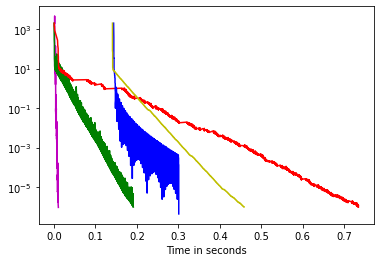

In [23]:
plt.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'm')
plt.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'g')
plt.plot(Lin_line_out.TimeTaken, Lin_line_out.GradientNorms, c = 'r')
plt.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'b')
plt.plot(Lin_vanilla_out.TimeTaken, Lin_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

## Boston Housing

In [24]:
from sklearn.datasets import load_boston as boston

In [25]:
I = Regression(1e-6, 60)
I.importLinearRegressionDataset(diabetes)
I.Adaptive_Linear_Reg("output/Lin_Test_Adap_boston.csv")
I.Grad_LineSearch_Linear_Reg("output/Lin_Test_LS_boston.csv")
I.Vanilla_Linear_Reg("output/Lin_Test_Van_boston.csv")
I.Barzilai_Linear_Reg("output/Lin_Test_Baz_boston.csv")
I.Nesterov_Linear_Reg("output/Lin_Test_Nest_boston.csv")

<ipython-input-1-cf99a8526701>:114: RuntimeWarning: divide by zero encountered in double_scalars
  while 1 > ( self.gradNorm/np.linalg.norm(self.g_Lin(self.x - lam*self.grad) - self.grad) ):


In [26]:
read_lin("boston")

In [27]:
print("Van final", Lin_vanilla_out.tail())
print("Adap final", Lin_adap_out.tail())
print("LS final", Lin_line_out.tail())
print("Baz final", Lin_baz_out.tail())
print("Nest final", Lin_nest_out.tail())

Van final       GradientNorms  TimeTaken  FunctionValues
7526   1.008335e-06   0.466159    5.746948e+06
7527   1.006190e-06   0.466159    5.746948e+06
7528   1.004049e-06   0.466159    5.746948e+06
7529   1.001913e-06   0.466159    5.746948e+06
7530   9.997821e-07   0.466159    5.746948e+06
Adap final       GradientNorms  TimeTaken  FunctionValues
2109   3.066264e-06   0.177603    5.746948e+06
2110   2.742780e-06   0.177603    5.746948e+06
2111   1.554906e-06   0.177603    5.746948e+06
2112   1.125788e-06   0.177603    5.746948e+06
2113   9.943583e-07   0.177603    5.746948e+06
LS final       GradientNorms  TimeTaken  FunctionValues
2358   1.116126e-06   1.343125    5.746948e+06
2359   1.058286e-06   1.343125    5.746948e+06
2360   1.007163e-06   1.343125    5.746948e+06
2361   1.297089e-06   1.363955    5.746948e+06
2362   9.963301e-07   1.364452    5.746948e+06
Baz final      GradientNorms  TimeTaken  FunctionValues
197   9.459663e-06   0.013354    5.746948e+06
198   4.254824e-06   0

In [28]:
print("Van final", Lin_vanilla_out.head())
print("Adap final", Lin_adap_out.head())
print("LS final", Lin_line_out.head())
print("Baz final", Lin_baz_out.head())
print("Nest final", Lin_nest_out.head())

Van final    GradientNorms  TimeTaken  FunctionValues
0    1949.096921   0.160623    6.422558e+06
1     548.196690   0.160623    5.899257e+06
2     403.269105   0.160623    5.834541e+06
3     300.400305   0.160623    5.799328e+06
4     226.288533   0.160623    5.779692e+06
Adap final    GradientNorms  TimeTaken  FunctionValues
0    1949.096921        0.0    6.422558e+06
1    2418.216599        0.0    6.513601e+06
2    1135.984056        0.0    5.939425e+06
3     593.217566        0.0    5.817109e+06
4     332.201650        0.0    5.782568e+06
LS final    GradientNorms  TimeTaken  FunctionValues
0    1949.096921   0.000455    6.422558e+06
1     546.680448   0.000977    5.898422e+06
2     126.675611   0.001447    5.760372e+06
3      76.018658   0.001944    5.754373e+06
4      44.418675   0.001944    5.753279e+06
Baz final    GradientNorms  TimeTaken  FunctionValues
0    1949.096921   0.001449    6.422558e+06
1    1491.672665   0.001945    6.200631e+06
2     504.823364   0.001945    5.877

In [29]:
np.argmax(np.where(Lin_line_out.TimeTaken >0.5, 1, 0))

1180

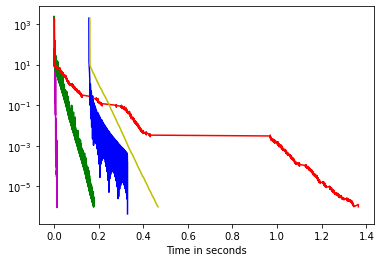

In [30]:
plt.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'm')
plt.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'g')
plt.plot(Lin_line_out.TimeTaken, Lin_line_out.GradientNorms, c = 'r')
plt.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'b')
plt.plot(Lin_vanilla_out.TimeTaken, Lin_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

## Breast Cancer

In [31]:
from sklearn.datasets import load_breast_cancer as cancer

In [32]:
K = Regression(1e-6, 60)
K.importLogisticRegressionDataset(cancer)
K.Adaptive_Logistic_Reg("output/Log_Test_Adap_cancer.csv")
K.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_cancer.csv")
K.Vanilla_Logistic_Reg("output/Log_Test_Van_cancer.csv")
K.Barzilai_Logistic_Reg("output/Log_Test_Baz_cancer.csv")
K.Nesterov_Logistic_Reg("output/Log_Test_Nest_cancer.csv")

<ipython-input-1-cf99a8526701>:244: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, w, X): return 1.0/(1 + np.exp(-(X @ w))) # sigmoid function
<ipython-input-1-cf99a8526701>:329: RuntimeWarning: divide by zero encountered in double_scalars
  self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
<ipython-input-1-cf99a8526701>:353: RuntimeWarning: divide by zero encountered in double_scalars
  while 1>(self.gradNorm/np.linalg.norm(self.g_Log(self.weights - lam*self.grad) - self.grad)):


In [33]:
read_log("cancer")

In [34]:
print("Van final", Log_vanilla_out.tail())
print("Adap final", Log_adap_out.tail())
print("LS final", Log_line_out.tail())
print("Baz final", Log_baz_out.tail())
print("Nest final", Log_nest_out.tail())

Van final        GradientNorms  TimeTaken  FunctionValues  Accuracy
83200       0.254534  59.997850        0.053539       1.0
83201       0.254532  59.998346        0.053539       1.0
83202       0.254530  59.998841        0.053539       1.0
83203       0.254528  59.999834        0.053539       1.0
83204       0.254526  60.000330        0.053539       1.0
Adap final        GradientNorms  TimeTaken  FunctionValues  Accuracy
73045       0.008448  59.996518        0.026533  0.982456
73046       0.008453  59.997510        0.026533  0.982456
73047       0.008575  59.998502        0.026533  0.982456
73048       0.014652  59.999493        0.026533  0.982456
73049       0.024310  60.000486        0.026533  0.982456
LS final        GradientNorms  TimeTaken  FunctionValues  Accuracy
11105       0.043580  59.975336        0.032633  0.982456
11106       0.040199  59.986248        0.032633  0.982456
11107       0.040832  59.993192        0.032633  0.982456
11108       0.041035  59.998152        0.0

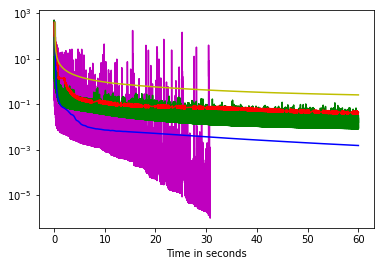

In [35]:
plt.plot(Log_baz_out.TimeTaken, Log_baz_out.GradientNorms, c = 'm')
plt.plot(Log_adap_out.TimeTaken, Log_adap_out.GradientNorms, c = 'g')
plt.plot(Log_line_out.TimeTaken, Log_line_out.GradientNorms, c = 'r')
plt.plot(Log_nest_out.TimeTaken, Log_nest_out.GradientNorms, c = 'b')
plt.plot(Log_vanilla_out.TimeTaken, Log_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

## Digits

In [38]:
from sklearn.datasets import load_digits as digits

In [39]:
dig = digits(n_class=2, return_X_y=True)

In [40]:
D = Regression(1e-6, 60)
D.importLogisticRegressionDataset(digits, multi=True)
D.Adaptive_Logistic_Reg("output/Log_Test_Adap_digits.csv")
D.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_digits.csv")
D.Vanilla_Logistic_Reg("output/Log_Test_Van_digits.csv")
D.Barzilai_Logistic_Reg("output/Log_Test_Baz_digits.csv")
D.Nesterov_Logistic_Reg("output/Log_Test_Nest_digits.csv")

<ipython-input-1-cf99a8526701>:250: RuntimeWarning: invalid value encountered in true_divide
  norm_X = 1 - ((maxs - X)/rng)


LinAlgError: SVD did not converge

In [27]:
D = Regression(1e-12, 60)
D.importLogisticRegressionDataset(digits, multi=True)

<ipython-input-1-cf99a8526701>:250: RuntimeWarning: invalid value encountered in true_divide
  norm_X = 1 - ((maxs - X)/rng)


In [33]:
H.normalise(dig[0][0])

array([0.        , 0.        , 0.33333333, 0.86666667, 0.6       ,
       0.06666667, 0.        , 0.        , 0.        , 0.        ,
       0.86666667, 1.        , 0.66666667, 1.        , 0.33333333,
       0.        , 0.        , 0.2       , 1.        , 0.13333333,
       0.        , 0.73333333, 0.53333333, 0.        , 0.        ,
       0.26666667, 0.8       , 0.        , 0.        , 0.53333333,
       0.53333333, 0.        , 0.        , 0.33333333, 0.53333333,
       0.        , 0.        , 0.6       , 0.53333333, 0.        ,
       0.        , 0.26666667, 0.73333333, 0.        , 0.06666667,
       0.8       , 0.46666667, 0.        , 0.        , 0.13333333,
       0.93333333, 0.33333333, 0.66666667, 0.8       , 0.        ,
       0.        , 0.        , 0.        , 0.4       , 0.86666667,
       0.66666667, 0.        , 0.        , 0.        ])

In [28]:
D.xTrain[0]

array([1.        ,        nan, 0.        , 0.        , 0.5       ,
       0.75      , 0.5625    , 0.18181818,        nan,        nan,
       0.        , 0.3125    , 1.        , 1.        , 1.        ,
       0.36363636,        nan, 0.        , 0.        , 0.5625    ,
       1.        , 1.        , 0.6875    , 0.        ,        nan,
       0.        , 0.21428571, 1.        , 1.        , 1.        ,
       0.3125    , 0.        ,        nan,        nan, 0.36363636,
       1.        , 1.        , 1.        , 0.25      , 0.        ,
              nan,        nan, 0.125     , 0.9375    , 1.        ,
       1.        , 0.1875    , 0.        ,        nan,        nan,
       0.        , 0.5       , 1.        , 1.        , 0.5625    ,
       0.        , 0.        ,        nan, 0.        , 0.        ,
       0.5625    , 0.73333333, 0.375     , 0.        , 0.        ])

In [37]:
D = Regression(1e-12, 60)
D.importLogisticRegressionDataset(digits, multi=True)
D.Adaptive_Logistic_Reg("output/Log_Test_Adap_digits.csv")
D.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_digits.csv")
# D.Vanilla_Logistic_Reg("output/Log_Test_Van_digits.csv")
D.Barzilai_Logistic_Reg("output/Log_Test_Baz_digits.csv")
# D.Nesterov_Logistic_Reg("output/Log_Test_Nest_digits.csv")

NameError: name 'digits' is not defined

KeyError: 0

# Other stuff

Oscilation in Gradient values (last 200 iterations)

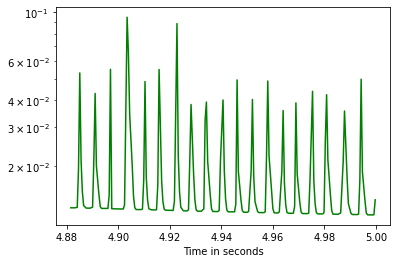

In [47]:
plt.plot(Lin_adap_out.TimeTaken.iloc[-200:-1], Lin_adap_out.GradientNorms.iloc[-200:-1], c = 'g')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

non-monotone method

Oscilation in Function values (last 200 iterations)

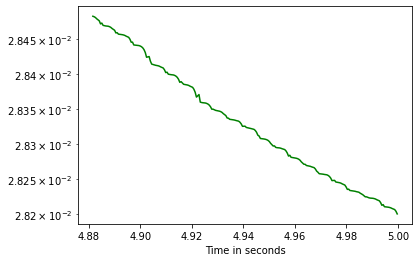

In [48]:
plt.plot(Lin_adap_out.TimeTaken.iloc[-200:-1], Lin_adap_out.FunctionValues.iloc[-200:-1], c = 'g')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

In [50]:
print("Van final", Log_vanilla_out.tail())
print("Adap final", Log_adap_out.tail())
print("LS final", Log_line_out.tail())
print("Baz final", Log_baz_out.tail())
print("Nest final", Log_nest_out.tail())

Van final        GradientNorms  TimeTaken  FunctionValues  Accuracy
40901       0.169685   4.999646        0.103069       0.9
40902       0.169682   4.999646        0.103069       0.9
40903       0.169680   4.999646        0.103068       0.9
40904       0.169678   4.999646        0.103067       0.9
40905       0.169675   5.000142        0.103067       0.9
Adap final        GradientNorms  TimeTaken  FunctionValues  Accuracy
25862       0.010151   4.999189        0.006087       0.9
25863       0.007823   4.999684        0.006087       0.9
25864       0.007117   4.999684        0.006087       0.9
25865       0.007040   4.999684        0.006087       0.9
25866       0.007039   5.000223        0.006086       0.9
LS final      GradientNorms  TimeTaken  FunctionValues  Accuracy
306       0.420536   1.953322        0.137341       0.9
307       0.370990   1.957789        0.137280       0.9
308       0.456602   1.966725        0.137101       0.9
309       0.365408   1.971178        0.137042     

In [51]:
Log_nest_out.Accuracy

0        0.009953
1        0.010453
2        0.010453
3        0.010947
4        0.010947
           ...   
39200    4.999750
39201    4.999750
39202    4.999750
39203    4.999750
39204    5.000245
Name: Accuracy, Length: 39205, dtype: float64

Check Lipschitz approx with SVD holds...

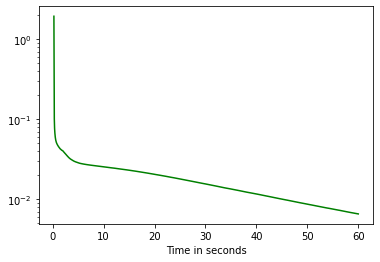

In [36]:
plt.plot(Log_nest_out.TimeTaken, Log_nest_out.FunctionValues, c = 'g')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()